---
title: "基于MNIST全量数据集的神经网络训练"
author: "逃之夭夭"
date: "2026-01-30"
categories: [deep learning, fastai]
image: "images/index.jpg"
---

> 训练你的第一个神经网络



## 神经网络训练流程

下图是训练神经网络基本的七个步骤：

1. 初始化权重参数，一般采用随机化权重也会有良好的效果；
2. 通过神经网络的计算，得到预测值；
3. 计算损失函数，损失函数是衡量预测值与真实值之间差异的函数，损失函数越小，预测值与真实值越接近；
4. 计算梯度，采用SGD（随机梯度下降）算法计算梯度，梯度是损失函数对权重参数的偏导数，表示损失函数在权重参数处的变化率；
5. 更新权重参数，根据梯度更新权重参数，使得损失函数最小化；
6. 重复步骤2-5，直到损失函数收敛；
7. 停止神经网络训练，一般取决于两种情况：
    - 达到预设的训练次数；
    - 损失函数收敛到预设的阈值。


```{mermaid}
graph LR
  init --> predict --> loss --> gradient --> step --> stop
  step -- repeat --> predict
```

## MNIST数据集

MNIST数据集是手写数字（0-9）的图片数据集，包含60000个训练样本和10000个测试样本。每个样本是一个28x28的灰度图像，表示一个手写数字。

加载MNIST数据集

In [1]:
# fastai课程预设置导入包
import fastbook
fastbook.setup_book()

from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST)

查看MNIST数据集目录结构

In [3]:
path.ls()

[Path('D:/User/ChenBo/.fastai/data/mnist_png/testing'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training')]

In [4]:
training_path = path/'training'
training_path.ls()

[Path('D:/User/ChenBo/.fastai/data/mnist_png/training/0'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/1'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/2'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/3'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/4'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/5'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/6'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/7'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/8'), Path('D:/User/ChenBo/.fastai/data/mnist_png/training/9')]

In [5]:
testing_path = path/'testing'
testing_path.ls()

[Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/0'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/1'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/2'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/3'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/4'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/5'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/6'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/7'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/8'), Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/9')]

数据集中的每一张图片都是类似下图所示的一张手写阿拉伯数字

In [6]:
zero_path = training_path/'0'
img_0 = Image.open(zero_path.ls()[0])
img_0

## 开始训练

### 构建神经网络输入

计算机并不认识图片，需要将图片转换为数字，才能进行训练。

每张图片由28 * 28的像素点组成，每个像素点由0-255的灰度值表示，0表示白色，255表示黑色。（现代的彩色图片是基于RGB三个通道确定一个像素点）

神经网络需要基于矩阵乘法进行大量并行计算，因此我们需要将[28 * 28]像素点压缩到一个维度上，构成一个784维的向量（一阶张量）。

最终60000张训练集图片构成[60000, 784]的矩阵（二阶张量）

### 创建基座模型

为了使后续的模型训练有参照，每一个神经网络训练之前都应该定义一个可以快速实现的基座模型。

一个简单明了的思路是像素相似度。基于训练集图像计算出每个数字（0-9）的所有图像的像素平均值，分类时计算模型和验证集的L1范式（也成为平均绝对差）值，分类为差值最小的数字

由于该简单模型确定为像素平均值，因此不需要进行训练，步骤简化为：

```{mermaid}
graph LR
  predict --> loss --> stop
```

In [7]:
# 将训练集0-9的Path加载到一个list中
training_paths = [training_path/f'{i}' for i in range(10)]
training_paths

[Path('D:/User/ChenBo/.fastai/data/mnist_png/training/0'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/1'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/2'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/3'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/4'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/5'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/6'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/7'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/8'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/training/9')]

In [8]:
# 将训练集所有图像转换为tensor，构建为一个包含60000个tensor的list，每个tensor为[28, 28]的二阶张量
training_nums = [[tensor(Image.open(image)) for image in path.ls()] for path in training_paths]
len(training_nums)

10

>❓ 为什么一个Image对象可以通过tensor构造函数转换为tensor
>
>核心在于 `Array Interface`（数组接口）协议：
>协议对接： PIL的Image类实现了`__array_interface__`属性，主动向外暴露内存指针和形状；
>底层识别： `torch.tensor`的构造逻辑会自动检测此属性，实现类似`NumPy`的无缝数据拷贝。

In [9]:
# 计算每个数字的像素平均值
# 1. 堆叠张量
# 2. 转成float类型
# 3. 基于维度0（即我们堆叠图片的方向）取平均值
# 4. 归一化像素值（/255，使像素值分布在[0, 1]区间）
means = [torch.stack(number).float().mean(0)/255 for number in training_nums]

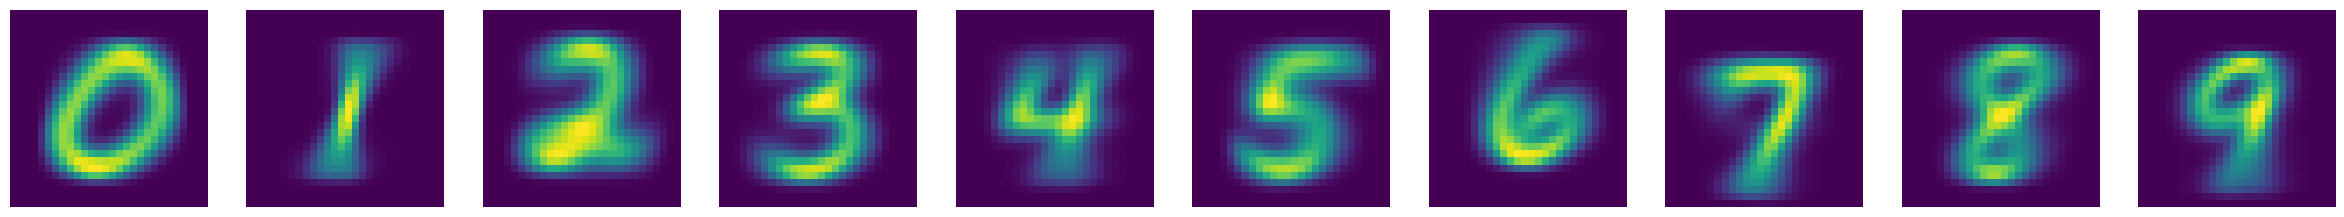

In [10]:
# 查看0-9在MNIST训练集平均像素下的图像
show_images(means)

In [11]:
#加载测试集
testing_paths = [testing_path/f'{i}' for i in range(10)]
testing_paths

[Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/0'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/1'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/2'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/3'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/4'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/5'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/6'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/7'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/8'),
 Path('D:/User/ChenBo/.fastai/data/mnist_png/testing/9')]

In [12]:
# 堆叠10个数字平均像素图像
mean_stack = torch.stack(means)
mean_stack.shape

torch.Size([10, 28, 28])

In [13]:
#定义损失函数
def mean_loss(preds, targets):
    return (preds - targets.unsqueeze(1)).abs().mean((-1, -2)).argmin(1)

In [14]:
# 加载测试集
testing_nums = [[tensor(Image.open(image)) for image in path.ls()] for path in testing_paths]
len(testing_nums)

10

In [15]:
# 计算验证集的准确度
similarity_accuracy = []

for i,test_num in enumerate(testing_nums):
  curr = (mean_loss(mean_stack, torch.stack(test_num)) == i).float().mean()
  similarity_accuracy.append(curr)
  print(f"accuracy of {i}: ", curr.item())

accuracy of 0:  0.9132652878761292
accuracy of 1:  0.9964757561683655
accuracy of 2:  0.5145348906517029
accuracy of 3:  0.7405940890312195
accuracy of 4:  0.6537678241729736
accuracy of 5:  0.22757847607135773
accuracy of 6:  0.8486430048942566
accuracy of 7:  0.7821011543273926
accuracy of 8:  0.6529774069786072
accuracy of 9:  0.8334985375404358


In [16]:
# 平均准确率
torch.stack(similarity_accuracy).mean().item()

0.7163436412811279

可见这么简单的一个模型（不需要训练），仅通过像素平均值，准确率就达到了71.63%，作为我们的基座模型，是一个很好的起点。

但是其余接近30%判断错误的图像究竟是长什么样呢，以至于容易混淆？让我们一探究竟

In [17]:
# 查看testing数据集中0的图像
mean_loss(mean_stack, torch.stack(testing_nums[0]))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 9, 6, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0,


可以看到第10张图片（索引下标为9）被误判成了6,让我们加载下这张图片看看

In [18]:
testing_zero = testing_paths[0].ls()
img_0_9 = Image.open(testing_zero[9])
img_0_9

这个`0`确实长的有点犯规，有那么一丢丢像6

再看下第13张（索引下标为12）长得像3的图片

In [19]:
img_0_12 = Image.open(testing_zero[12])
img_0_12

这个`0`就和3没什么关联性了，可见基于像素平均值是一个很粗糙的模型构建法。

下面让我们正式进入神经网络训练，看看神经网络的魔力吧！

### 神经网络训练

#### 加载数据集DataLoaders

fastai中的数据集由一个(训练集，验证集)通过DataLoaders构造函数，即dls = DataLoaders(train_dl, test_dl)创建
dl由DataSet拆分成mini-batch产生
DataSet是由(模型输入x， 对应的标签y)元组组成的列表

In [20]:
# 构造模型输入x，即由所有训练集图像的一维向量（tensor）构成的list
training_tensors = [tensor(Image.open(image)) for path in training_paths for image in path.ls()]
training_stack = torch.stack(training_tensors).float() / 255
train_x = training_stack.view(-1, 28 * 28)
train_x.shape

torch.Size([60000, 784])

In [21]:
# 构造模型输入对应的标签y
# 构建标签y有两种方案，与神经网络的建模相对应。
#     1. 使用one-hot编码，将标签y编码成shape=[10]的一阶张量（向量），神经网络输出要做softmax归一化处理。
#     2. 直接编码0-9对应的数字，神经网络输出保持Logits，不需要做softmax，损失函数使用交叉熵。
# 这里我们采用方案二
train_y = []
for i, path in enumerate(training_paths):
    train_y.extend([i] * len(path.ls()))

train_y = tensor(train_y)
train_y.shape

torch.Size([60000])

In [22]:
# 构造训练集dataloder
train_ds = list(zip(train_x, train_y))
train_dl = DataLoader(train_ds, batch_size=256)

In [23]:
# 如法炮制测试集合的dataloder
testing_tensors = [tensor(Image.open(image)) for path in testing_paths for image in path.ls()]
testing_stack = torch.stack(testing_tensors).float() / 255
test_x = testing_stack.view(-1, 28 * 28)

test_y = []
for i, path in enumerate(testing_paths):
    test_y.extend([i] * len(path.ls()))
test_y = tensor(test_y)

test_ds = list(zip(test_x, test_y))
test_dl = DataLoader(test_ds, batch_size=256)

In [24]:
dls = DataLoaders(train_dl, test_dl)

#### 初始化权重

In [25]:
# 使用pytorch的nn.Sequential模块定义最简单的神经网络，由两层线性层、一层ReLU激活函数组成。
# 初始维度为28 * 28=784（每一张数据集图片由28 * 28的像素点组成），输出维度为10（分别代表0-9），中间层维度为30（中间层维度可以随意设置，表示神经网络可以捕获的特征数量）。
# 模型的权重由nn.Linear()随机初始化。

simple_net = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

#### 定义损失函数

交叉熵损失函数：直接使用CrossEntropyLossFlat()函数即可，等同于nn.CrossEntropyLoss，区别在于CrossEntropyLossFlat会展平inputs和targets

#### 定义优化器

优化器采用随机梯度下降SGD

#### 定义正确率指标

In [26]:
def batch_accuracy(preds, targets):
    return (preds.argmax(1) == targets).float().mean()

#### 训练神经网络

In [27]:

learn = Learner(
    dls = dls,
    model = simple_net,
    loss_func=CrossEntropyLossFlat(),
    opt_func=SGD,
    metrics=batch_accuracy
)

learn.remove_cbs(ProgressCallback)

In [28]:
learn.fit_one_cycle(40, lr_max=0.1)

[0, 2.058319330215454, 2.217005491256714, 0.1054999977350235, '00:00']
[1, 1.026645541191101, 3.093644857406616, 0.10090000182390213, '00:00']
[2, 0.46824803948402405, 3.1218841075897217, 0.10790000110864639, '00:00']
[3, 0.2767549157142639, 3.022745132446289, 0.17020000517368317, '00:00']
[4, 0.2017069160938263, 3.0426149368286133, 0.22300000488758087, '00:00']
[5, 0.16536171734333038, 3.1070761680603027, 0.2531999945640564, '00:00']
[6, 0.14760544896125793, 3.160271406173706, 0.27799999713897705, '00:00']
[7, 0.13931012153625488, 3.1762616634368896, 0.29660001397132874, '00:00']
[8, 0.1304607093334198, 3.268145799636841, 0.2971000075340271, '00:00']
[9, 0.12770448625087738, 3.2473626136779785, 0.30469998717308044, '00:00']
[10, 0.13348078727722168, 2.9868013858795166, 0.34529998898506165, '00:00']
[11, 0.13116277754306793, 2.9267468452453613, 0.3483000099658966, '00:00']
[12, 0.1418938934803009, 2.7756187915802, 0.3547999858856201, '00:00']
[13, 0.14047884941101074, 2.686028242111206

## 加深网络

In [29]:
simple_net2 = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [30]:
learn2 = Learner(
    dls = dls,
    model = simple_net2,
    loss_func=CrossEntropyLossFlat(),
    opt_func=SGD,
    metrics=batch_accuracy
)

learn2.remove_cbs(ProgressCallback)

In [31]:
learn2.fit_one_cycle(40, lr_max=0.1)

[0, 2.284194231033325, 2.2780888080596924, 0.10909999907016754, '00:00']
[1, 1.7273132801055908, 3.121453285217285, 0.10090000182390213, '00:00']
[2, 0.6533521413803101, 4.710193157196045, 0.10090000182390213, '00:00']
[3, 0.3517478406429291, 4.200509071350098, 0.10300000011920929, '00:00']
[4, 0.26247790455818176, 3.8570432662963867, 0.1111999973654747, '00:00']
[5, 0.22667746245861053, 3.7390215396881104, 0.13210000097751617, '00:00']
[6, 0.19849027693271637, 3.7495152950286865, 0.1736000031232834, '00:00']
[7, 0.1698937714099884, 3.976940631866455, 0.1899999976158142, '00:00']
[8, 0.16094760596752167, 3.9729621410369873, 0.24040000140666962, '00:00']
[9, 0.15071767568588257, 4.124275207519531, 0.20829999446868896, '00:00']
[10, 0.1586325764656067, 3.9294629096984863, 0.22370000183582306, '00:00']
[11, 0.1524275243282318, 3.6151387691497803, 0.27469998598098755, '00:00']
[12, 0.13830970227718353, 3.7923121452331543, 0.26330000162124634, '00:00']
[13, 0.1439690738916397, 3.43160867691

可以看出，增加一层网络实际上并没有提高准确率，反而略微下降，一个原因是网络变深了但是参数量差别不大

## 使用RESNET18

In [33]:
path = untar_data(URLs.MNIST)

In [34]:
dls = ImageDataLoaders.from_folder(path,train="training",valid="testing")

In [35]:
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.remove_cbs(ProgressCallback)

In [36]:
learn.fit_one_cycle(5, 0.1)

[0, 1.1184285879135132, 791.0833129882812, 0.8259999752044678, '00:34']
[1, 0.929822564125061, 3.3093323707580566, 0.9657999873161316, '00:38']
[2, 0.4890580475330353, 1.0338960886001587, 0.9674000144004822, '00:32']
[3, 0.08392318338155746, 0.047650303691625595, 0.989799976348877, '00:31']
[4, 0.026931514963507652, 0.021246496587991714, 0.9937999844551086, '00:31']


正确率直接飙到99.38%，Amazing！！！

## 小结

MNIST数据集的神经网络训练作为深度学习领域的HelloWorld，想要理解并跑通并不是一件简单的事。
正如Fastai创始人`Jeremy Howard`所说，要想深入深度学习领域，学习者必须保持坚韧。
比如对于我来说：
    2小时的课程可能对应于视频课程看3遍，jupyter notebook材料看3遍，不计其数的查询与搜索，一次次的暂停课件并卡住，才堪堪理解并完成这篇博客。

但是如你所见，最后模型的准确率是惊人的。基座模型71.63%->单层神经网络93.45%->resnet18 99.38%，而resnet18不过是一个2015年的早已过时的模型。
其中的每一步都环环相扣，然而这只是魔术，并不是魔法，一个人人都可以做到的魔术表演。

## References

1. [fastai对应课程链接](https://course.fast.ai/Lessons/lesson3.html)